## Table of Contents

* 0. [Introduction](#introduction)
* 1. [Data Loading](#dataloading)
    * 1.1 [Libraries](#libs)
    * 1.2 [Load Datasets](#loadatasets)
* 2. [Data Preprocessing and EDA](#preprocessing)
    * 2.1 [Join Datasets](#joindatasets)
    * 2.2 [Missing Values](#missvals)
    * 2.3 [Duplicates](#duplcheck)
    * 2.4 [Outliers](#outliers)
    * 2.5 [Category Change](#catchange)
    * 2.6 [Target Variable](#targetvar)
    * 2.7 [Histograms of Numerical Features](#hists) 
    * 2.8 [Bar Charts of Categorical Features](#barcharts)
    * 2.9 [Scatter Plots of Numerical Features](#scatterplots)    
    * 2.10 [Correlation Matrix of Numerical Features](#corrmatrix)
    * 2.11 [Variable Transformations](#vartransform)
* 3. [Modeling](#modeling)
    * 3.1 [Tweedie Regressor](#tweedie)
    * 3.2 [Decision Tree Regressor](#dt)
    * 3.3 [K-Nearest Neighbors Regressor](#knn)
    * 3.4 [Neural Network](#nn)
    * 3.5 [Random Forest Regressor](#rf)
    * 3.6 [Suport Vector Regressor](#svr)
    * 3.7 [AdaBoost Regressor](#adaboost)
* 4. [Cross Validation](#crossval)
* 5. [Evaluation Metrics](#metrics)
* 6. [Evaluation Metrics](#plots)

## 0. Introduction <a class="anchor" id="introduction"></a>

In this notebook, we compare several regression models to generalized linear models when modeling the pure premium of insurance claims. We explore Decision tree, Random Forest, K-Nearest Neighbors, Support Vector Machine, Adaptive Boosting with Decision Tree Regressor as base estimator, and Neural Network approaches. We benchmarked these with a compound Poisson-Gammma Generalized Linear Model which is what's commonly used in actuarial data science. 

We explore these methods on a French motor third-party liability insurance dataset. 

[Dataset containing claim amounts for 26639 third-party liability policies](https://www.openml.org/d/41215)

[Dataset containing risk features for 678013 motor third-party liability policies (observed mostly on one year)](https://www.openml.org/d/41214)

In the two datasets, risk features are collected for 678013 motor third-party liability policies (observed mostly on one year), in addition to claim numbers by policy as well as their corresponding claim amounts. freMTPL2freq contains the risk features and claim counts, while freMTPL2sev contains claim amounts. Both tables can be linked together via the corresponding policy ID.

Insurance companies are usually interested in predicting claim frequency, claim severity, pure premium, and/or loss ratio for each policyholder in their portfolio.

In this notebook, we are predicting the **Pure Premium: Claim Amount / Exposure**.

A few definitions:

**Claim severity**: Claim amount per claim or occurrence

**Pure premium**: Claim amount per exposure

**Loss ratio**: Claim amount per premium amount

**Claim frequency**: Claims per exposure

**Policy**: contract between the insurance company and the policyholder.

**Claim**: request filed by a policyholder to the insurer provider for compensation for a covered loss.

**Claim amount**: amount of money the insurance pays to the policyholder.

**Exposure**: the duration of the insurance coverage of a given policy, in years.

## 1. Data Loading <a class="anchor" id="dataloading"></a>

### 1.1 Libraries<a class="anchor" id="libs"></a>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

### 1.2 Load Datasets <a class="anchor" id="loadatasets"></a>

In [13]:
def load_datasets():
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    data_freq = fetch_openml(data_id=41214, as_frame=True)["data"]

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    data_sev = fetch_openml(data_id=41215, as_frame=True)["data"] 
    
    return data_freq, data_sev

## 2. Data Preprocessing and EDA <a class="anchor" id="preprocessing"></a>

### 2.1 Join Datasets <a class="anchor" id="joindatasets"></a>

In [14]:
def join_datasets(n_samples=678013):
    
    data_freq, data_sev = load_datasets()
    
    data_freq["IDpol"] = data_freq["IDpol"].astype(int)
    data_freq.set_index("IDpol", inplace=True)
    
    # sum ClaimAmount over identical IDs
    data_sev = data_sev.groupby("IDpol").sum()
    
    # join the two datasets
    data = data_freq.join(data_sev, how="left")
    
    # unquote string fields
    for column_name in data.columns[data.dtypes.values == object]:
        data[column_name] = data[column_name].str.strip("'")
    return data.iloc[:n_samples]

df = join_datasets()

### 2.2 Check for Missing Values <a class="anchor" id="missvals"></a>

In [15]:
# replace NA/NaN values with 0
df["ClaimAmount"].fillna(0, inplace=True)

percent_missing_nans = df.isnull().sum() * 100 / len(df)
nans = pd.DataFrame({'col_name': df.columns, 'percent_missing': percent_missing_nans})
nans

,col_name,percent_missing
ClaimNb,ClaimNb,0.0
Exposure,Exposure,0.0
Area,Area,0.0
VehPower,VehPower,0.0
VehAge,VehAge,0.0
DrivAge,DrivAge,0.0
BonusMalus,BonusMalus,0.0
VehBrand,VehBrand,0.0
VehGas,VehGas,0.0
Density,Density,0.0


### 2.3 Check for Duplicated Rows <a class="anchor" id="duplcheck"></a>

In [16]:
duplicates = df[df.duplicated()]
duplicates

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1189,1.0,0.09,D,5.0,0.0,44.0,50.0,B12,Regular,665.0,R41,0.0
2263,1.0,0.05,D,7.0,0.0,47.0,50.0,B12,Regular,1662.0,R11,0.0
2707,1.0,0.75,E,10.0,10.0,34.0,100.0,B1,Regular,6570.0,R11,0.0
3495,1.0,0.07,C,7.0,0.0,72.0,50.0,B12,Regular,122.0,R93,0.0
3531,1.0,0.01,D,7.0,0.0,50.0,50.0,B12,Diesel,887.0,R22,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6114130,0.0,0.03,D,8.0,3.0,46.0,50.0,B12,Diesel,889.0,R82,0.0
6114144,0.0,0.03,D,4.0,0.0,48.0,100.0,B12,Regular,1541.0,R91,0.0
6114159,0.0,0.03,E,10.0,2.0,41.0,50.0,B12,Regular,4998.0,R11,0.0


### 2.4 Outliers <a class="anchor" id="outliers"></a>

In [17]:
# Filter out claims with zero amount 
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

### 2.5 Change of Category <a class="anchor" id="catchange"></a>

#### Types of Columns

In [18]:
df.dtypes

ClaimNb         float64
Exposure        float64
Area           category
VehPower        float64
VehAge          float64
DrivAge         float64
BonusMalus      float64
VehBrand       category
VehGas           object
Density         float64
Region         category
ClaimAmount     float64
dtype: object

In [19]:
df['Area'] = df['Area'].astype('object')
df['VehBrand'] = df['VehBrand'].astype('object')
df['Region'] = df['Region'].astype('object')

In [20]:
df.dtypes

ClaimNb        float64
Exposure       float64
Area            object
VehPower       float64
VehAge         float64
DrivAge        float64
BonusMalus     float64
VehBrand        object
VehGas          object
Density        float64
Region          object
ClaimAmount    float64
dtype: object

### 2.6 Target Variable <a class="anchor" id="targetvar"></a>

In [10]:
df["Target"] = df["ClaimAmount"] / df["Exposure"]

print(
    "Average Severity = {}".format(np.average(df["Target"], weights=df["Exposure"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

Average Severity = 145.5843892349478
Fraction of exposure with zero claims = 95.2%


### 2.7 Histograms of Numerical Features <a class="anchor" id="hists"></a>

array([[<AxesSubplot:title={'center':'ClaimNb'}>,
        <AxesSubplot:title={'center':'Exposure'}>,
        <AxesSubplot:title={'center':'VehPower'}>],
       [<AxesSubplot:title={'center':'VehAge'}>,
        <AxesSubplot:title={'center':'DrivAge'}>,
        <AxesSubplot:title={'center':'BonusMalus'}>],
       [<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'ClaimAmount'}>,
        <AxesSubplot:title={'center':'Target'}>]], dtype=object)

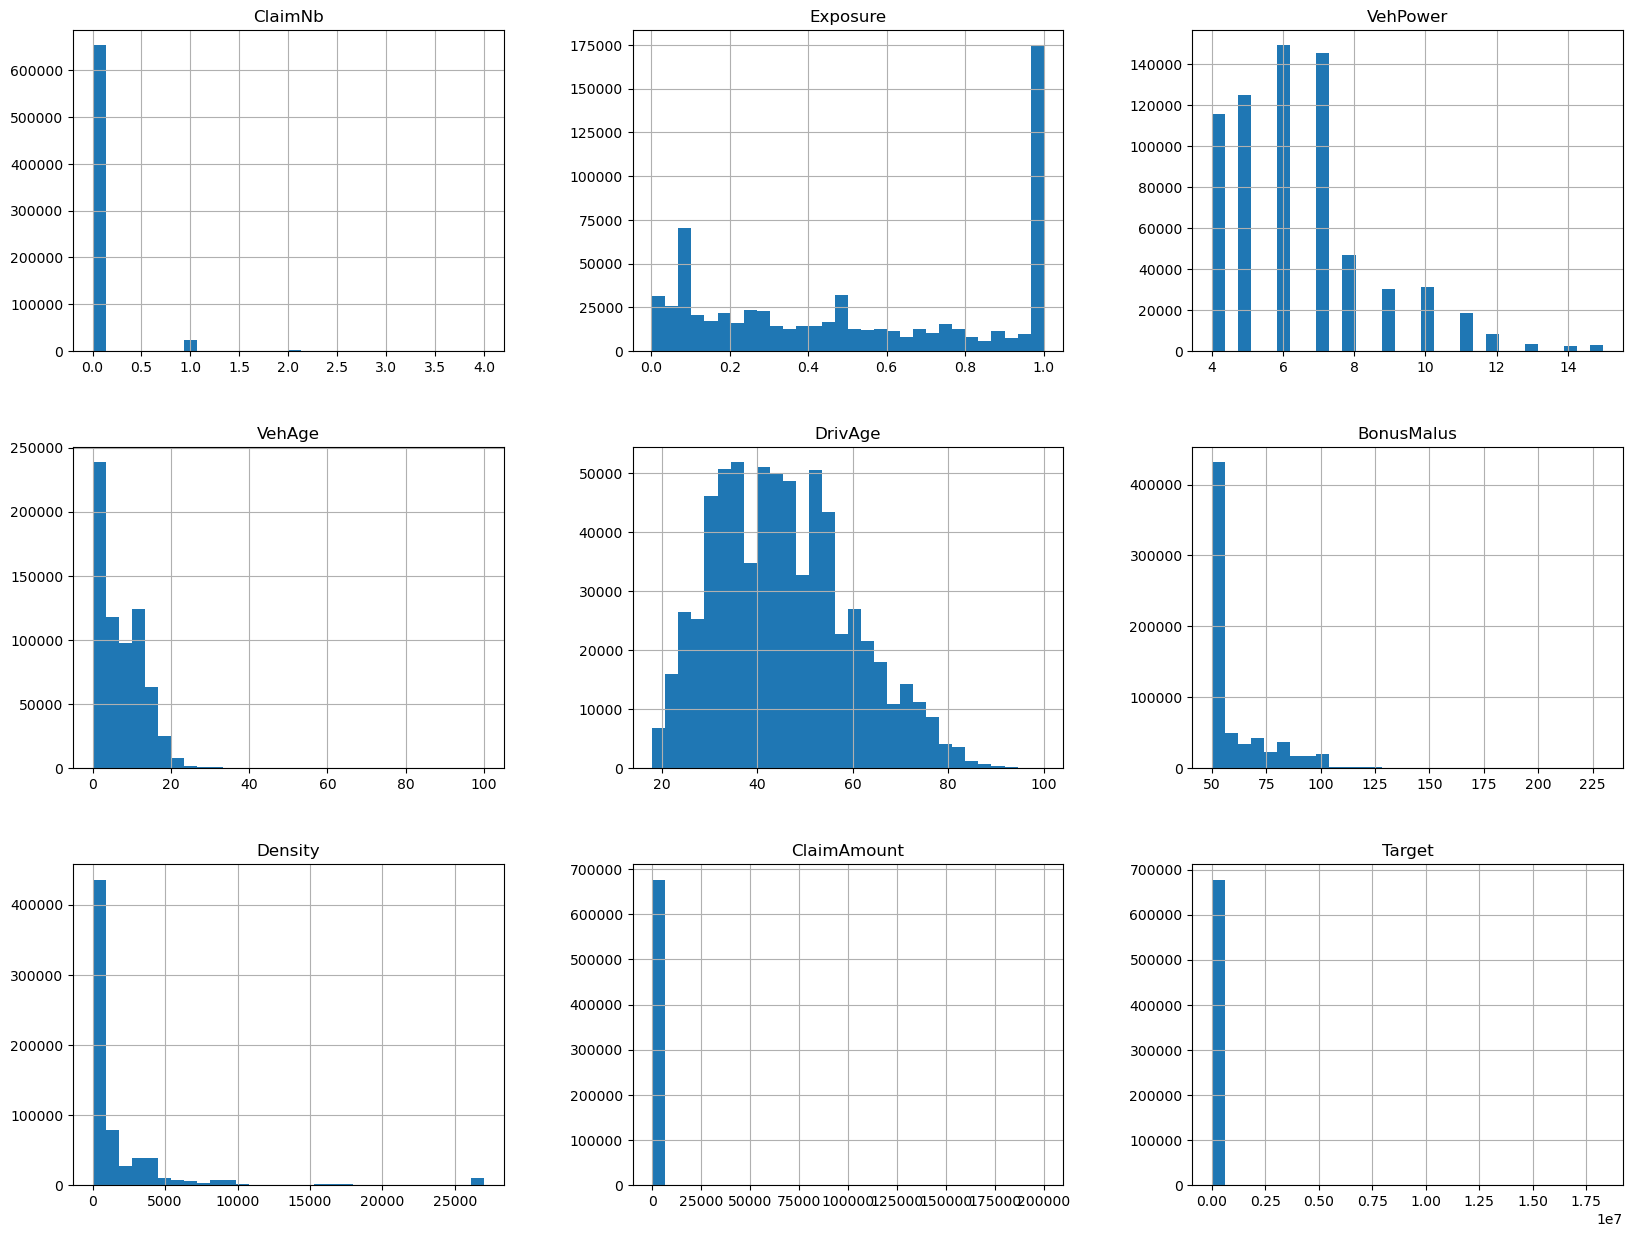

In [11]:
df.hist(bins = 30, figsize=(20, 15))

array([[<AxesSubplot:title={'center':'ClaimNb'}>,
        <AxesSubplot:title={'center':'VehAge'}>],
       [<AxesSubplot:title={'center':'DrivAge'}>,
        <AxesSubplot:title={'center':'BonusMalus'}>],
       [<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Target'}>]], dtype=object)

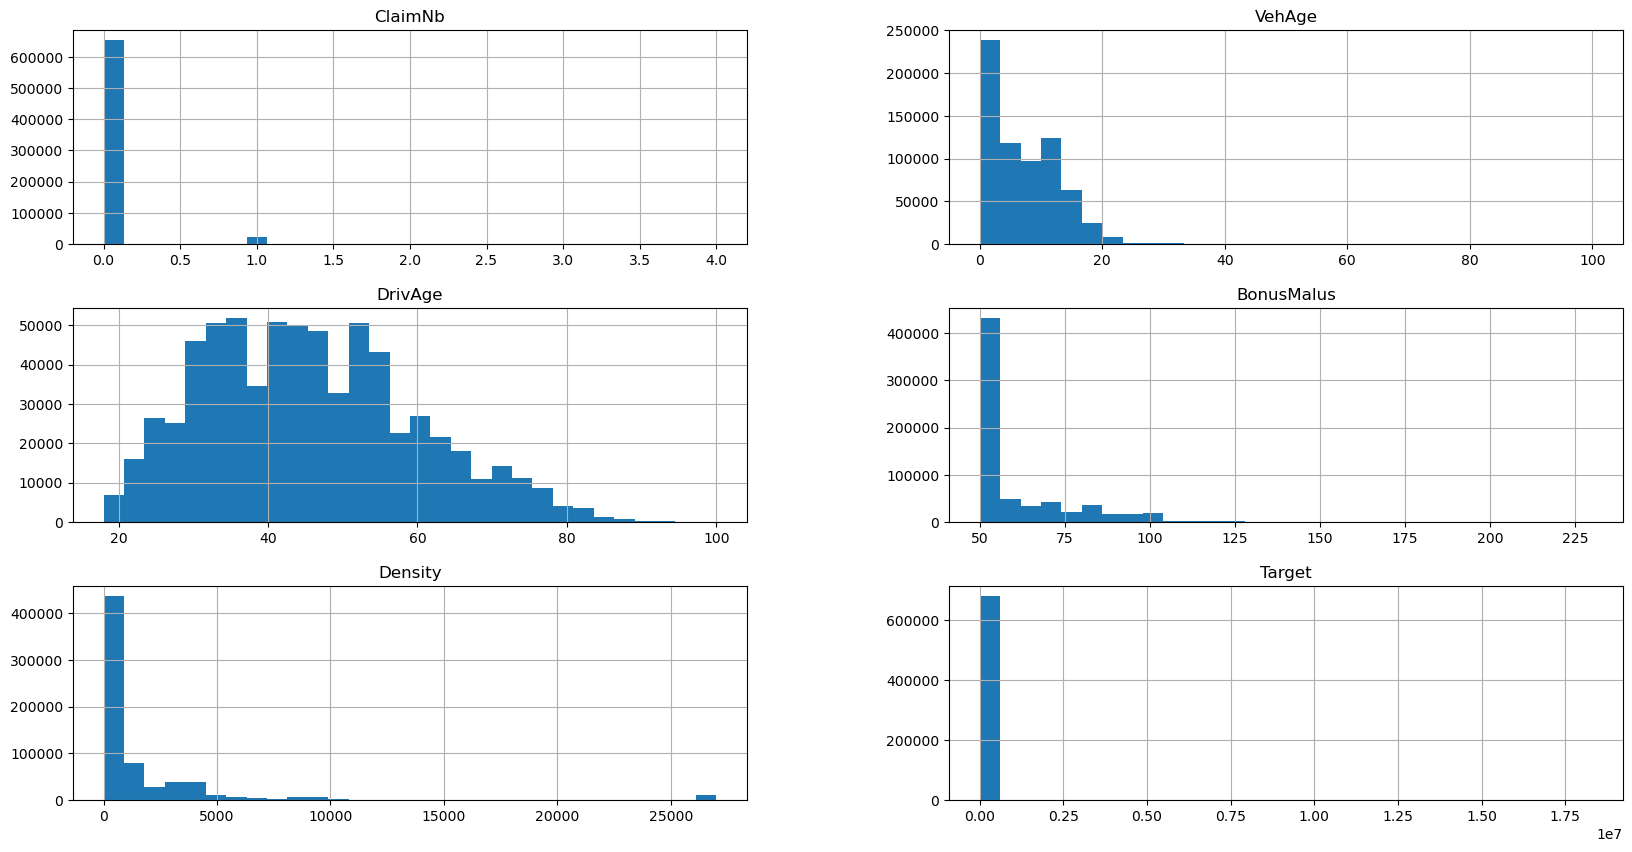

In [11]:
df5 = df.drop(['ClaimAmount','Exposure','VehPower'], axis=1)
df5.hist(bins = 30, figsize=(20, 10))

#### Log Scale Histograms of Numerical Features

array([[<AxesSubplot:title={'center':'ClaimNb'}>,
        <AxesSubplot:title={'center':'Exposure'}>,
        <AxesSubplot:title={'center':'VehPower'}>],
       [<AxesSubplot:title={'center':'VehAge'}>,
        <AxesSubplot:title={'center':'DrivAge'}>,
        <AxesSubplot:title={'center':'BonusMalus'}>],
       [<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'ClaimAmount'}>,
        <AxesSubplot:title={'center':'Target'}>]], dtype=object)

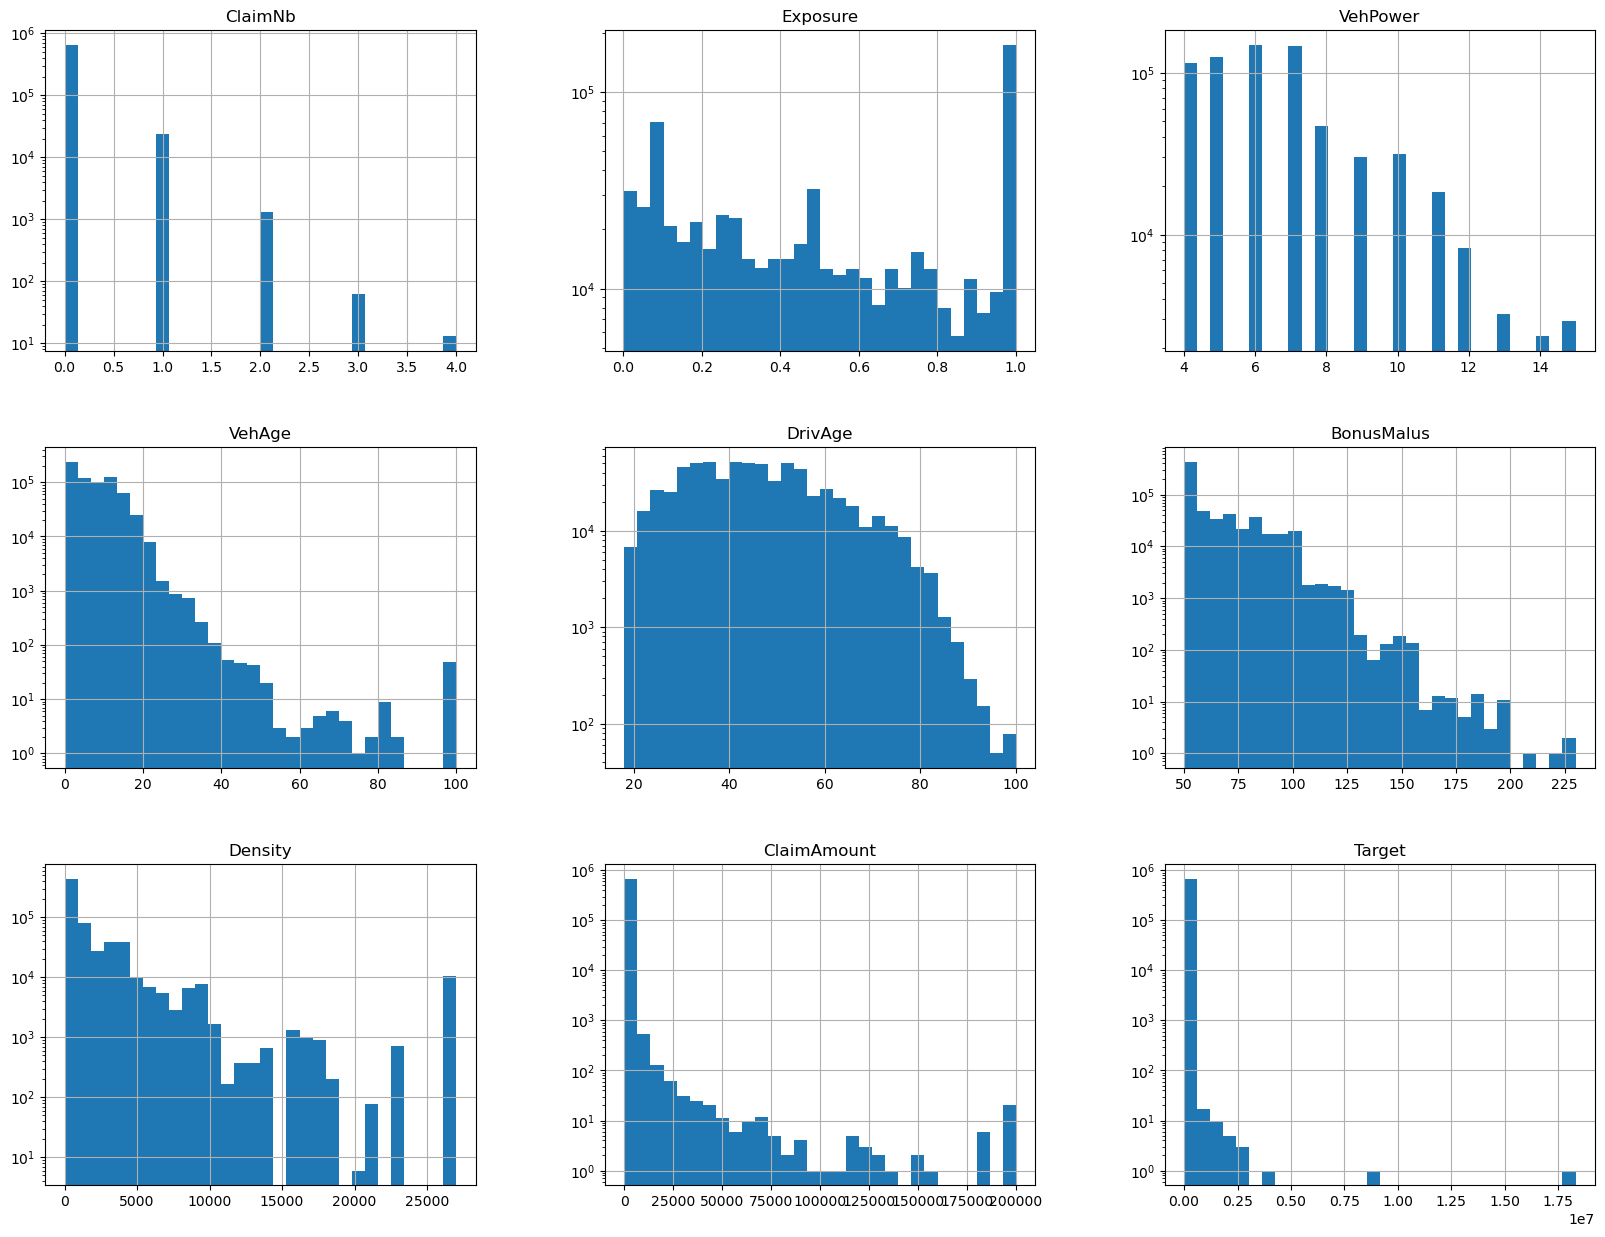

In [12]:
df.hist(bins = 30, log = True, figsize=(20, 15))

array([[<AxesSubplot:title={'center':'ClaimNb'}>,
        <AxesSubplot:title={'center':'VehAge'}>],
       [<AxesSubplot:title={'center':'DrivAge'}>,
        <AxesSubplot:title={'center':'BonusMalus'}>],
       [<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Target'}>]], dtype=object)

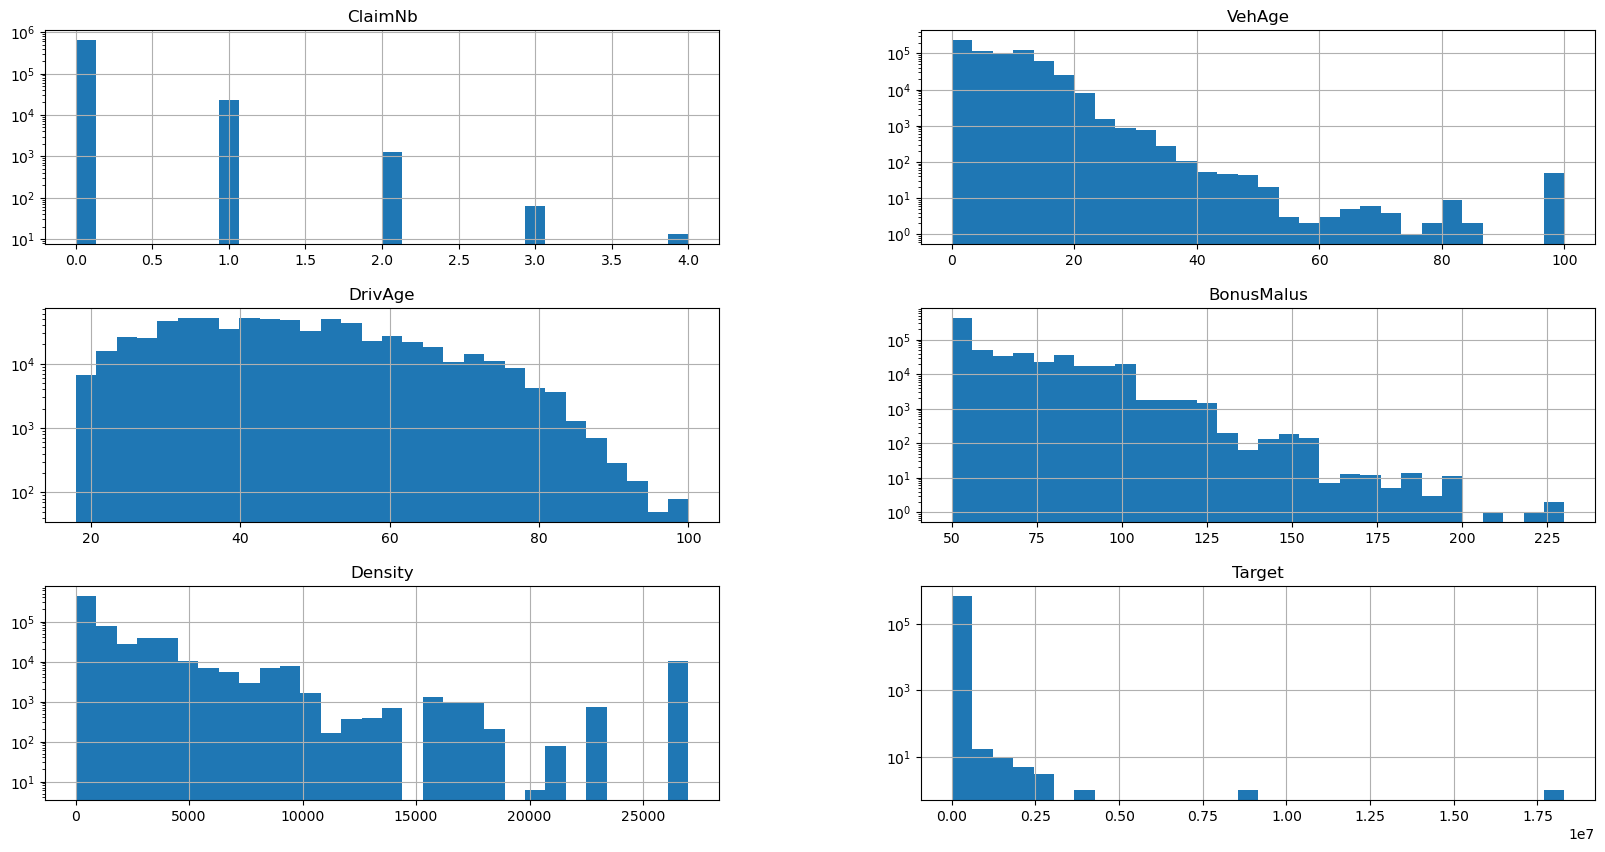

In [13]:
df5.hist(bins = 30, log = True, figsize=(20, 10))

### 2.8 Bar Charts of Categorical Features <a class="anchor" id="barcharts"></a>

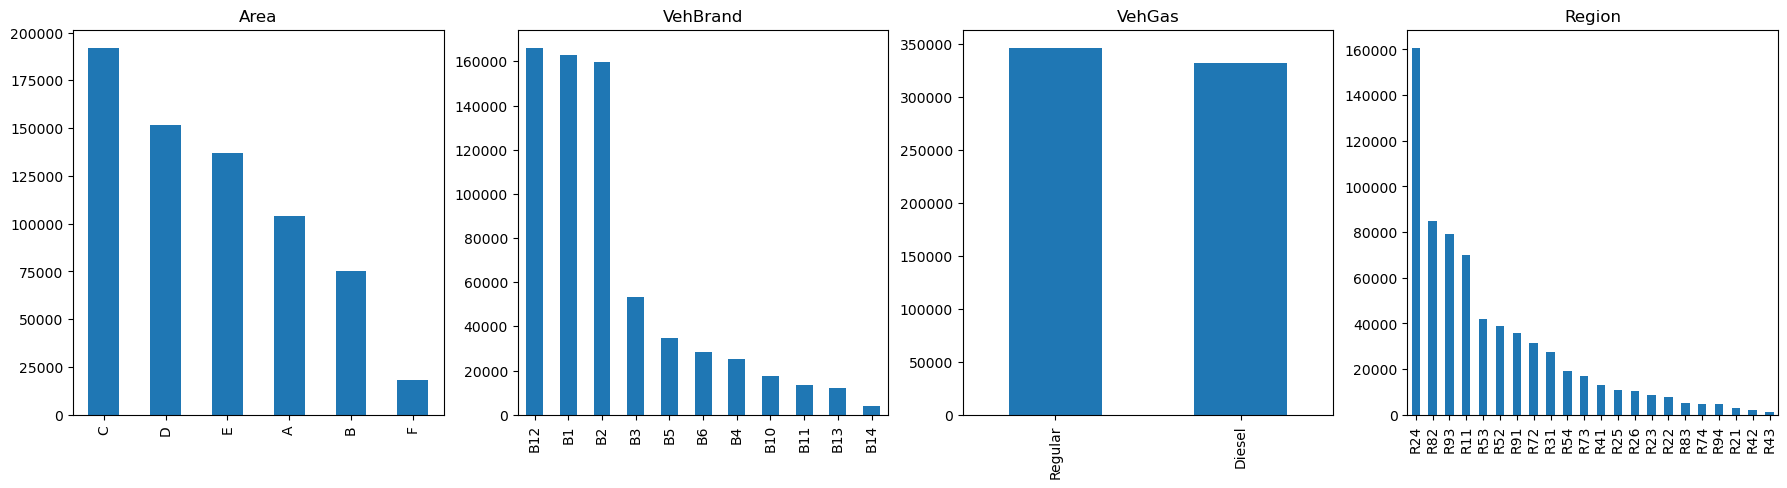

In [14]:
df_cat = df.select_dtypes(include=['object'])

fig, ax = plt.subplots(1, len(df_cat.columns.tolist()), figsize = (22,5))
for i, ft in enumerate(df_cat):
    df_cat[ft].value_counts().plot(kind = "bar", ax=ax[i]).set_title(ft)
plt.show()

<AxesSubplot:xlabel='ClaimAmount', ylabel='Region'>

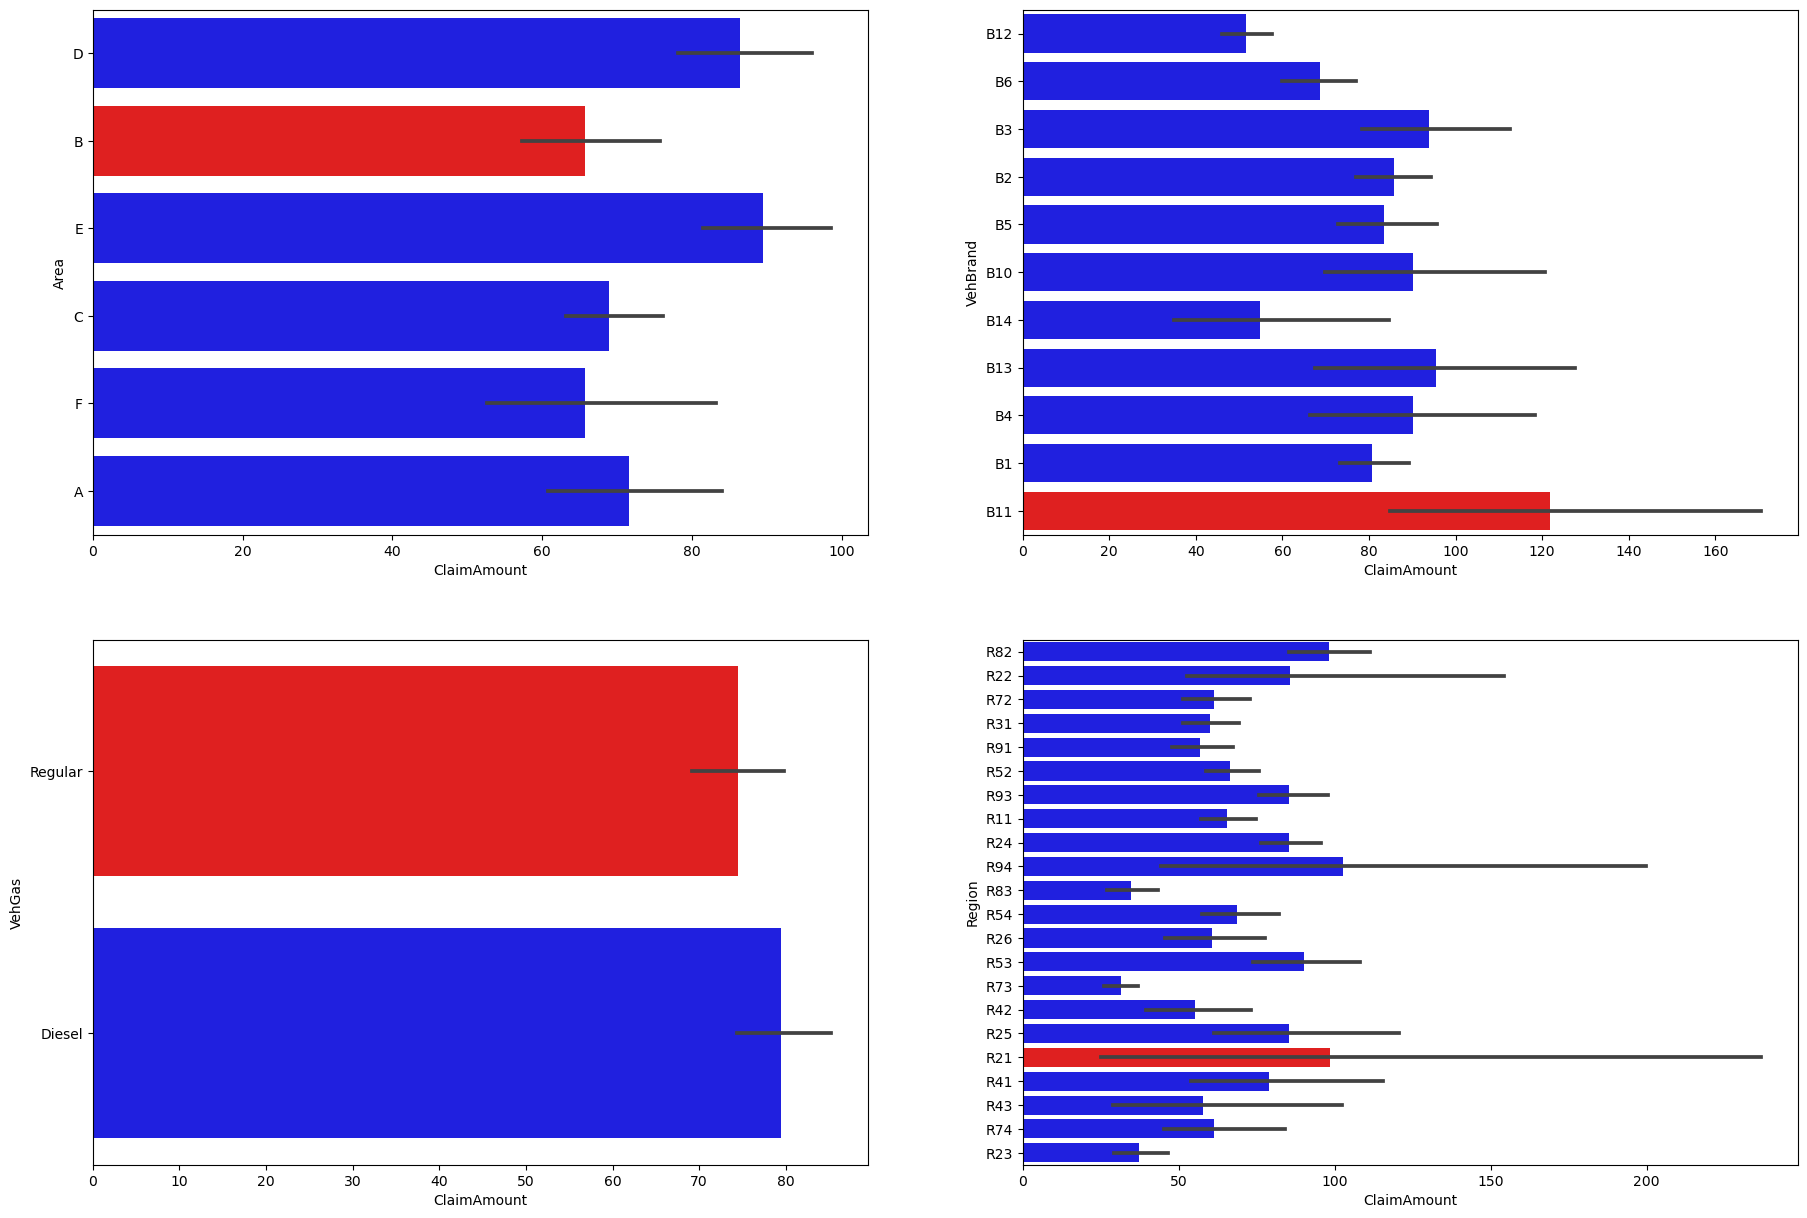

In [15]:
fig, axes = plt.subplots(2, 2, figsize = (22,15))

sns.barplot(x=df.ClaimAmount, y = df.Area, ax=axes[0,0] ,palette=["blue", "red", "blue","blue","blue","blue"])
sns.barplot(x=df.ClaimAmount, y = df.VehBrand, ax=axes[0,1], palette=["blue", "blue","blue","blue","blue","blue", "blue","blue","blue","blue", "red"])
sns.barplot(x=df.ClaimAmount, y = df.VehGas, ax=axes[1,0],palette=["red","blue"])
sns.barplot(x=df.ClaimAmount, y = df.Region, ax=axes[1,1],palette=["blue", "blue","blue","blue","blue","blue", "blue","blue","blue","blue",
                                                                   "blue","blue", "blue","blue","blue","blue","blue","red", "blue","blue","blue","blue"])

### 2.9 Scatter Plots of Numerical Features <a class="anchor" id="scatterplots"></a>

<AxesSubplot:xlabel='DrivAge', ylabel='ClaimNb'>

C:\Users\a_lite13\miniconda3\envs\nlp\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


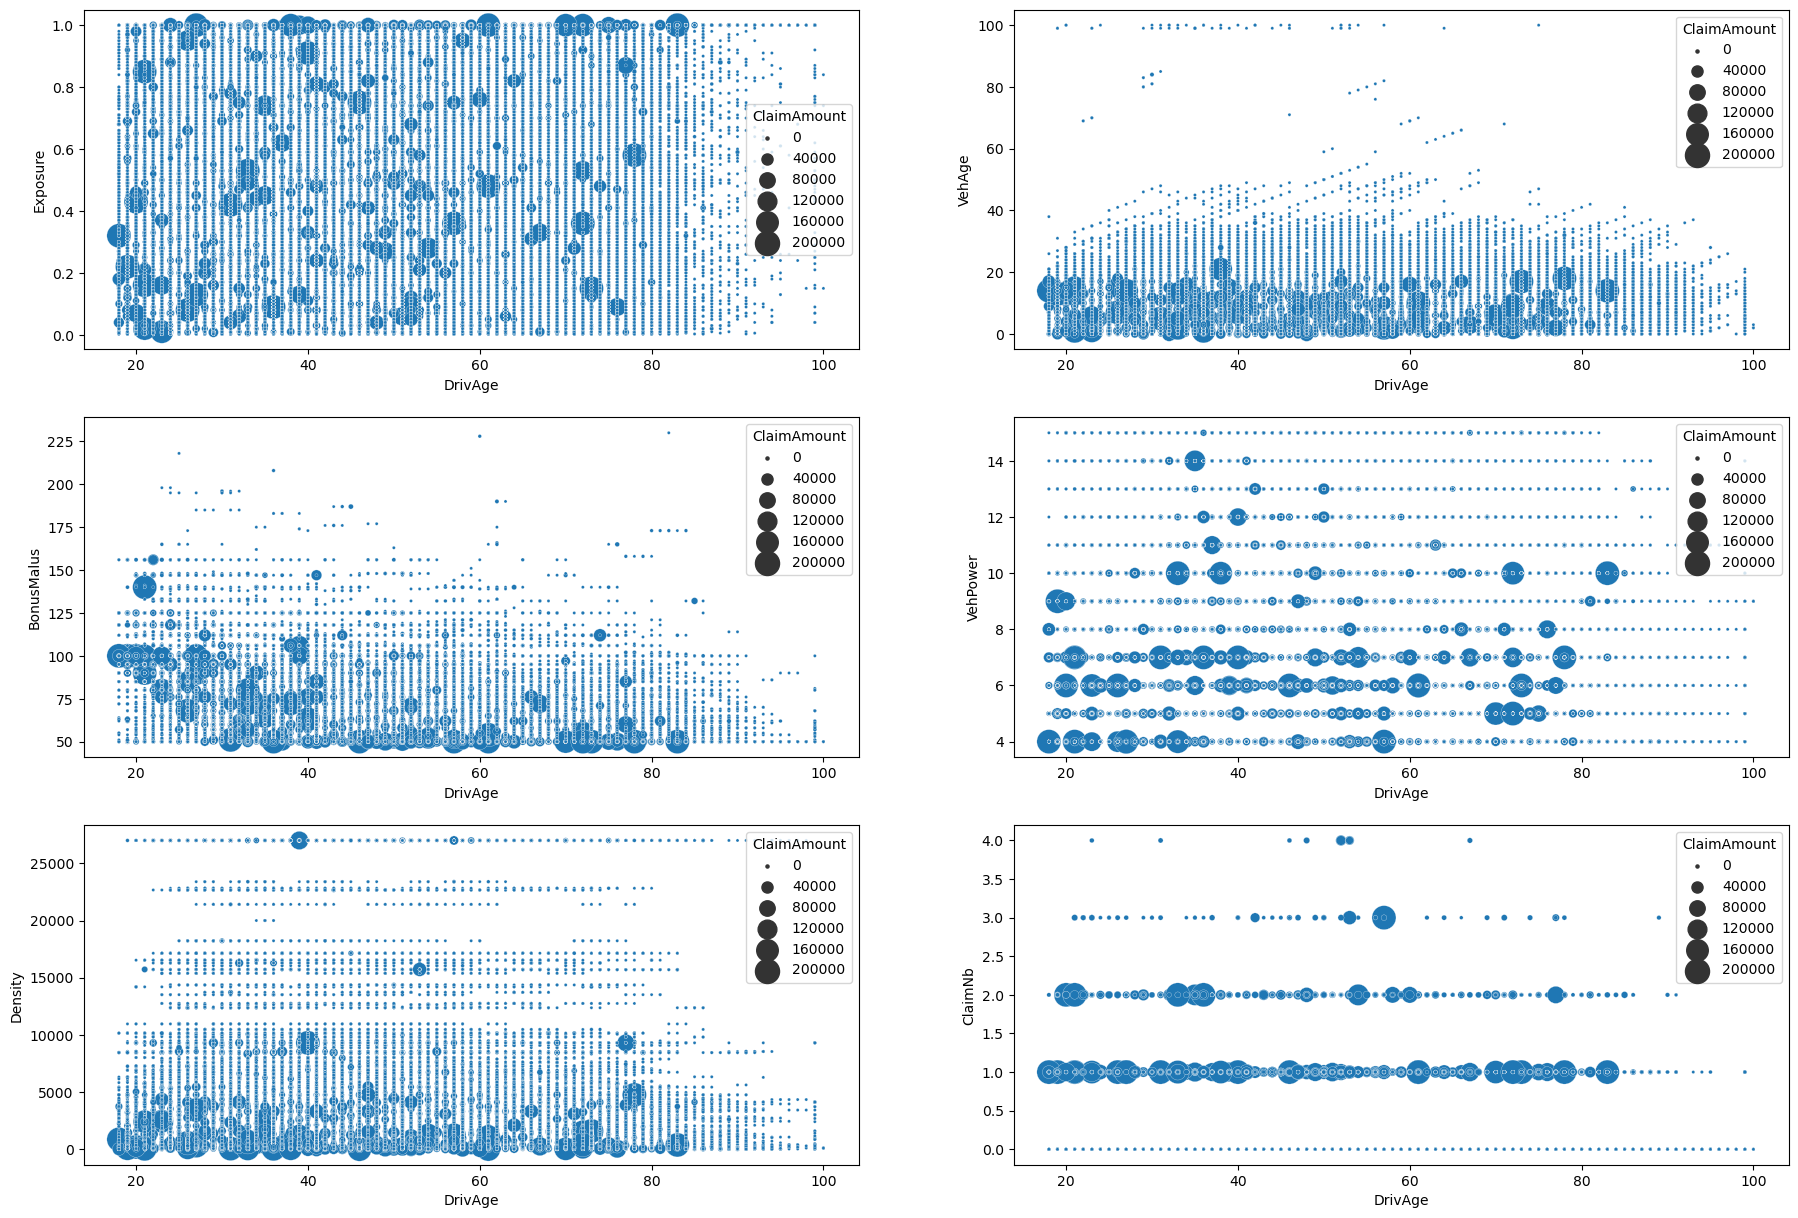

In [16]:
fig, axes = plt.subplots(3, 2, figsize = (22,15))
sns.scatterplot(x = df.DrivAge,y = df.Exposure, size=df.ClaimAmount, sizes= (5,300), ax=axes[0,0])
sns.scatterplot(x = df.DrivAge,y = df.VehAge, size=df.ClaimAmount, sizes= (5,300), ax=axes[0,1])
sns.scatterplot(x = df.DrivAge,y = df.BonusMalus, size=df.ClaimAmount, sizes= (5,300), ax=axes[1,0])
sns.scatterplot(x = df.DrivAge,y = df.VehPower, size=df.ClaimAmount, sizes= (5,300), ax=axes[1,1])
sns.scatterplot(x = df.DrivAge,y = df.Density, size=df.ClaimAmount, sizes= (5,300), ax=axes[2,0])
sns.scatterplot(x = df.DrivAge,y = df.ClaimNb, size=df.ClaimAmount, sizes= (5,300), ax=axes[2,1])

In [17]:
# fig, axes = plt.subplots(2, 2, figsize = (22,15))
# sns.scatterplot(x = df.DrivAge,y = df.Exposure, size=df.Target, sizes= (5,300), ax=axes[0,0])
# sns.scatterplot(x = df.DrivAge,y = df.Density, size=df.Target, sizes= (5,300), ax=axes[0,1])
# sns.scatterplot(x = df.DrivAge,y = df.BonusMalus, size=df.Target, sizes= (5,300), ax=axes[1,0])
# sns.scatterplot(x = df.DrivAge,y = df.VehAge, size=df.Target, sizes= (5,300), ax=axes[1,1])

#sns.scatterplot(x = df.DrivAge,y = df.VehAge, size=df.Target, sizes= (5,300), ax=axes[0,1])
#sns.scatterplot(x = df.DrivAge,y = df.VehPower, size=df.Target, sizes= (5,300), ax=axes[1,1])
#sns.scatterplot(x = df.DrivAge,y = df.ClaimNb, size=df.Target, sizes= (5,300), ax=axes[2,1])

### 2.10 Correlation Matrix of Numerical Features <a class="anchor" id="corrmatrix"></a>

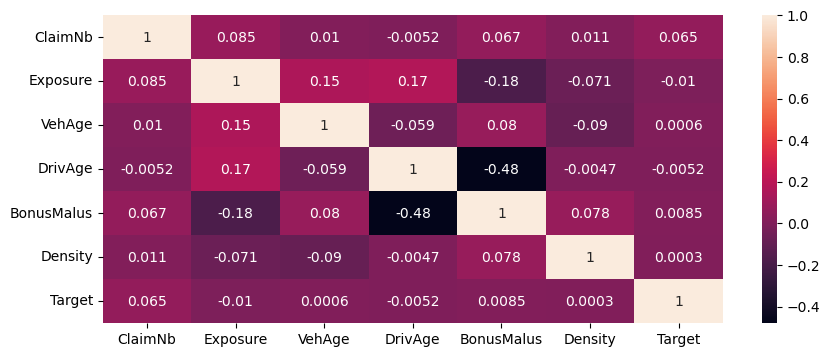

In [18]:
df2 = df.drop(['ClaimAmount','VehPower'], axis=1)
fig = plt.figure(figsize =(10, 4))
ax = sns.heatmap(df2.corr(), annot=True)

### 2.11 Variable Transformations <a class="anchor" id="vartransform"></a>

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)


feature_eng_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
) 

## 3. Modeling <a class="anchor" id="modeling"></a>

array([[<AxesSubplot:title={'center':'Vehicle Age'}>,
        <AxesSubplot:title={'center':'Driver Age'}>]], dtype=object)

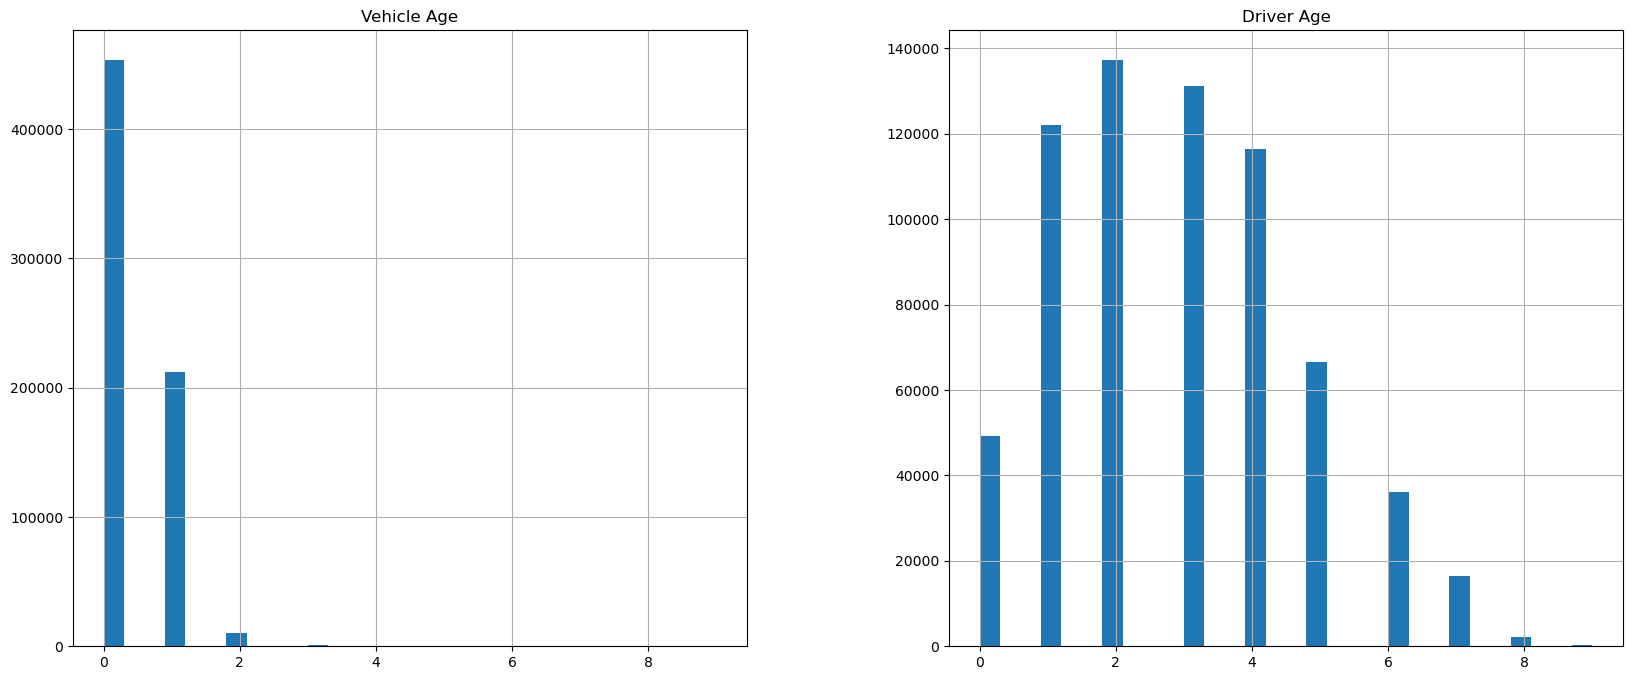

In [20]:
df3 = df[["VehAge", "DrivAge"]]
bin_10 = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
bin_10.fit(df3)
df4 = pd.DataFrame(bin_10.transform(df3))
df4.rename(columns = {0:'Vehicle Age', 
                       1:'Driver Age'}, inplace = True)
df4.hist(bins=30, figsize=(20, 8))

In [21]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)
x_train = df_train.loc[:, df_train.columns != "Target"]
y_train = df_train["Target"]
x_test = df_test.loc[:, df_test.columns != "Target"]
y_test = df_test["Target"]

### 3.1 Tweedie Regressor <a class="anchor" id="tweedie"></a>

In [22]:
from sklearn.linear_model import TweedieRegressor

TweedieRegressor_glm = make_pipeline(
        feature_eng_trans,
        TweedieRegressor(alpha = 1, max_iter = 10000, power = 1.7),
)

TweedieRegressor_glm.fit(
   x_train, y_train, tweedieregressor__sample_weight = df_train["Exposure"]
)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['VehAge', 'DrivAge']),
                                                 ('onehot_categorical',
                                                  OneHotEncoder(),
                                                  ['VehBrand', 'VehPower',
                                                   'VehGas', 'Region',
                                                   'Area']),
                                                 ('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                            

### 3.2 Decision Tree Regressor <a class="anchor" id="dt"></a>

In [23]:
from sklearn import tree

dt = make_pipeline(
        feature_eng_trans,
       tree.DecisionTreeRegressor(max_depth = 5, min_samples_split = 2),

)

dt.fit(x_train, y_train, decisiontreeregressor__sample_weight=df_train["Exposure"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['VehAge', 'DrivAge']),
                                                 ('onehot_categorical',
                                                  OneHotEncoder(),
                                                  ['VehBrand', 'VehPower',
                                                   'VehGas', 'Region',
                                                   'Area']),
                                                 ('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                            

### 3.3 K-nearest Neighbors Regressor <a class="anchor" id="knn"></a>

In [24]:
from sklearn.neighbors import KNeighborsRegressor


knn = make_pipeline(
        feature_eng_trans,
       KNeighborsRegressor(n_neighbors = 29, weights = 'uniform'),

)

knn.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['VehAge', 'DrivAge']),
                                                 ('onehot_categorical',
                                                  OneHotEncoder(),
                                                  ['VehBrand', 'VehPower',
                                                   'VehGas', 'Region',
                                                   'Area']),
                                                 ('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                            

### 3.4 Neural Network <a class="anchor" id="nn"></a>

In [25]:
class OneHotEncoder:

    def __init__(self, colNames):
        self.colNames = colNames

    def fit(self, *args, **kwargs):
        return self

    def transform(self, df):
        dummies = pd.get_dummies(df[self.colNames])
        df = pd.concat([df, dummies], axis=1)
        return df.drop(columns=self.colNames)

oneHotEncoder = OneHotEncoder(df_cat.columns)

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.wrappers.scikit_learn import KerasRegressor

def build_model(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error']):
    NN_model = Sequential()
    NN_model.add(Dense(128, kernel_initializer='normal', input_dim = 49, activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    NN_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return NN_model

from keras.callbacks import ModelCheckpoint
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

epochs = 300
batch_size = 128
validation_split = 0.2
callbacks = callbacks_list

nn_model = KerasRegressor(
    build_fn=build_model,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = validation_split,
    callbacks = callbacks_list
)

nn = make_pipeline(
    oneHotEncoder,
   nn_model
)

nn.fit(x_train, y_train)

Epoch 1/300
2817/2840 [============================>.] - ETA: 0s - loss: 221.3573 - mean_absolute_error: 221.3573
Epoch 00001: val_loss improved from inf to 171.57814, saving model to Weights-001--171.57814.hdf5
2840/2840 [==============================] - 4s 2ms/step - loss: 220.2549 - mean_absolute_error: 220.2549 - val_loss: 171.5781 - val_mean_absolute_error: 171.5781
Epoch 2/300
2809/2840 [============================>.] - ETA: 0s - loss: 216.0151 - mean_absolute_error: 216.0151
Epoch 00002: val_loss did not improve from 171.57814
2840/2840 [==============================] - 4s 1ms/step - loss: 215.7381 - mean_absolute_error: 215.7381 - val_loss: 172.0910 - val_mean_absolute_error: 172.0910
Epoch 3/300
2836/2840 [============================>.] - ETA: 0s - loss: 214.5522 - mean_absolute_error: 214.5522
Epoch 00003: val_loss did not improve from 171.57814
2840/2840 [==============================] - 4s 2ms/step - loss: 214.3268 - mean_absolute_error: 214.3268 - val_loss: 171.6781 -

Epoch 24/300
2829/2840 [============================>.] - ETA: 0s - loss: 206.8242 - mean_absolute_error: 206.8242
Epoch 00024: val_loss did not improve from 162.32458
2840/2840 [==============================] - 4s 2ms/step - loss: 206.4942 - mean_absolute_error: 206.4942 - val_loss: 165.5670 - val_mean_absolute_error: 165.5670
Epoch 25/300
2805/2840 [============================>.] - ETA: 0s - loss: 204.2319 - mean_absolute_error: 204.2319
Epoch 00025: val_loss improved from 162.32458 to 159.70624, saving model to Weights-025--159.70624.hdf5
2840/2840 [==============================] - 6s 2ms/step - loss: 202.3396 - mean_absolute_error: 202.3396 - val_loss: 159.7062 - val_mean_absolute_error: 159.7062
Epoch 26/300
2814/2840 [============================>.] - ETA: 0s - loss: 202.4947 - mean_absolute_error: 202.4947
Epoch 00026: val_loss did not improve from 159.70624
2840/2840 [==============================] - 4s 2ms/step - loss: 201.3634 - mean_absolute_error: 201.3634 - val_loss: 1

Epoch 48/300
2834/2840 [============================>.] - ETA: 0s - loss: 190.3524 - mean_absolute_error: 190.3524
Epoch 00048: val_loss did not improve from 136.76711
2840/2840 [==============================] - 4s 2ms/step - loss: 190.1472 - mean_absolute_error: 190.1472 - val_loss: 149.4533 - val_mean_absolute_error: 149.4533
Epoch 49/300
2817/2840 [============================>.] - ETA: 0s - loss: 192.2810 - mean_absolute_error: 192.2810
Epoch 00049: val_loss did not improve from 136.76711
2840/2840 [==============================] - 4s 2ms/step - loss: 193.1646 - mean_absolute_error: 193.1646 - val_loss: 156.1773 - val_mean_absolute_error: 156.1773
Epoch 50/300
2833/2840 [============================>.] - ETA: 0s - loss: 188.8833 - mean_absolute_error: 188.8833
Epoch 00050: val_loss did not improve from 136.76711
2840/2840 [==============================] - 4s 2ms/step - loss: 188.5974 - mean_absolute_error: 188.5974 - val_loss: 138.7807 - val_mean_absolute_error: 138.7807
Epoch 5

Epoch 73/300
2828/2840 [============================>.] - ETA: 0s - loss: 184.3468 - mean_absolute_error: 184.3468
Epoch 00073: val_loss did not improve from 135.36774
2840/2840 [==============================] - 4s 2ms/step - loss: 183.9848 - mean_absolute_error: 183.9848 - val_loss: 146.7598 - val_mean_absolute_error: 146.7598
Epoch 74/300
2804/2840 [============================>.] - ETA: 0s - loss: 183.6865 - mean_absolute_error: 183.6865
Epoch 00074: val_loss did not improve from 135.36774
2840/2840 [==============================] - 4s 1ms/step - loss: 182.6645 - mean_absolute_error: 182.6645 - val_loss: 143.7065 - val_mean_absolute_error: 143.7065
Epoch 75/300
2825/2840 [============================>.] - ETA: 0s - loss: 180.4899 - mean_absolute_error: 180.4899
Epoch 00075: val_loss did not improve from 135.36774
2840/2840 [==============================] - 5s 2ms/step - loss: 179.7482 - mean_absolute_error: 179.7482 - val_loss: 145.9764 - val_mean_absolute_error: 145.9764
Epoch 7

Epoch 122/300
2804/2840 [============================>.] - ETA: 0s - loss: 167.4225 - mean_absolute_error: 167.4225
Epoch 00122: val_loss did not improve from 113.89962
2840/2840 [==============================] - 4s 2ms/step - loss: 172.4486 - mean_absolute_error: 172.4486 - val_loss: 130.3701 - val_mean_absolute_error: 130.3701
Epoch 123/300
2815/2840 [============================>.] - ETA: 0s - loss: 180.8815 - mean_absolute_error: 180.8815
Epoch 00123: val_loss did not improve from 113.89962
2840/2840 [==============================] - 4s 2ms/step - loss: 180.0986 - mean_absolute_error: 180.0986 - val_loss: 145.2992 - val_mean_absolute_error: 145.2992
Epoch 124/300
2835/2840 [============================>.] - ETA: 0s - loss: 174.0516 - mean_absolute_error: 174.0516
Epoch 00124: val_loss did not improve from 113.89962
2840/2840 [==============================] - 4s 2ms/step - loss: 173.8803 - mean_absolute_error: 173.8803 - val_loss: 118.4996 - val_mean_absolute_error: 118.4996
Epoc

Epoch 147/300
2832/2840 [============================>.] - ETA: 0s - loss: 180.1623 - mean_absolute_error: 180.1623
Epoch 00147: val_loss did not improve from 113.89962
2840/2840 [==============================] - 6s 2ms/step - loss: 179.8119 - mean_absolute_error: 179.8119 - val_loss: 121.9997 - val_mean_absolute_error: 121.9997
Epoch 148/300
2838/2840 [============================>.] - ETA: 0s - loss: 167.0280 - mean_absolute_error: 167.0280
Epoch 00148: val_loss did not improve from 113.89962
2840/2840 [==============================] - 4s 2ms/step - loss: 166.9720 - mean_absolute_error: 166.9720 - val_loss: 138.0028 - val_mean_absolute_error: 138.0028
Epoch 149/300
2807/2840 [============================>.] - ETA: 0s - loss: 167.1949 - mean_absolute_error: 167.1949
Epoch 00149: val_loss did not improve from 113.89962
2840/2840 [==============================] - 4s 2ms/step - loss: 166.3484 - mean_absolute_error: 166.3484 - val_loss: 120.6376 - val_mean_absolute_error: 120.6376
Epoc

Epoch 172/300
2821/2840 [============================>.] - ETA: 0s - loss: 180.6633 - mean_absolute_error: 180.6633
Epoch 00172: val_loss did not improve from 109.08910
2840/2840 [==============================] - 4s 2ms/step - loss: 179.9588 - mean_absolute_error: 179.9588 - val_loss: 171.0787 - val_mean_absolute_error: 171.0787
Epoch 173/300
2828/2840 [============================>.] - ETA: 0s - loss: 175.9113 - mean_absolute_error: 175.9113
Epoch 00173: val_loss did not improve from 109.08910
2840/2840 [==============================] - 4s 2ms/step - loss: 175.2890 - mean_absolute_error: 175.2890 - val_loss: 113.1172 - val_mean_absolute_error: 113.1172
Epoch 174/300
2830/2840 [============================>.] - ETA: 0s - loss: 181.9550 - mean_absolute_error: 181.9550
Epoch 00174: val_loss did not improve from 109.08910
2840/2840 [==============================] - 6s 2ms/step - loss: 181.4836 - mean_absolute_error: 181.4836 - val_loss: 116.6136 - val_mean_absolute_error: 116.6136
Epoc

Epoch 197/300
2809/2840 [============================>.] - ETA: 0s - loss: 168.5294 - mean_absolute_error: 168.5294
Epoch 00197: val_loss did not improve from 109.08910
2840/2840 [==============================] - 4s 1ms/step - loss: 170.6899 - mean_absolute_error: 170.6899 - val_loss: 123.7908 - val_mean_absolute_error: 123.7908
Epoch 198/300
2828/2840 [============================>.] - ETA: 0s - loss: 171.3953 - mean_absolute_error: 171.3953
Epoch 00198: val_loss did not improve from 109.08910
2840/2840 [==============================] - 4s 1ms/step - loss: 170.8507 - mean_absolute_error: 170.8507 - val_loss: 181.0491 - val_mean_absolute_error: 181.0491
Epoch 199/300
2809/2840 [============================>.] - ETA: 0s - loss: 171.0959 - mean_absolute_error: 171.0959
Epoch 00199: val_loss did not improve from 109.08910
2840/2840 [==============================] - 4s 2ms/step - loss: 170.3841 - mean_absolute_error: 170.3841 - val_loss: 126.3096 - val_mean_absolute_error: 126.3096
Epoc

Epoch 222/300
2805/2840 [============================>.] - ETA: 0s - loss: 175.2179 - mean_absolute_error: 175.2179
Epoch 00222: val_loss did not improve from 109.08910
2840/2840 [==============================] - 4s 2ms/step - loss: 175.0727 - mean_absolute_error: 175.0727 - val_loss: 119.9026 - val_mean_absolute_error: 119.9026
Epoch 223/300
2838/2840 [============================>.] - ETA: 0s - loss: 166.9275 - mean_absolute_error: 166.9275
Epoch 00223: val_loss did not improve from 109.08910
2840/2840 [==============================] - 4s 2ms/step - loss: 166.8598 - mean_absolute_error: 166.8598 - val_loss: 111.3758 - val_mean_absolute_error: 111.3758
Epoch 224/300
2816/2840 [============================>.] - ETA: 0s - loss: 154.5142 - mean_absolute_error: 154.5142
Epoch 00224: val_loss did not improve from 109.08910
2840/2840 [==============================] - 4s 1ms/step - loss: 159.1332 - mean_absolute_error: 159.1332 - val_loss: 115.1838 - val_mean_absolute_error: 115.1838
Epoc

Epoch 247/300
2813/2840 [============================>.] - ETA: 0s - loss: 161.5282 - mean_absolute_error: 161.5282
Epoch 00247: val_loss did not improve from 106.87996
2840/2840 [==============================] - 4s 2ms/step - loss: 161.1653 - mean_absolute_error: 161.1653 - val_loss: 150.6256 - val_mean_absolute_error: 150.6256
Epoch 248/300
2840/2840 [==============================] - ETA: 0s - loss: 165.3528 - mean_absolute_error: 165.3528
Epoch 00248: val_loss did not improve from 106.87996
2840/2840 [==============================] - 4s 2ms/step - loss: 165.3528 - mean_absolute_error: 165.3528 - val_loss: 151.8156 - val_mean_absolute_error: 151.8156
Epoch 249/300
2813/2840 [============================>.] - ETA: 0s - loss: 160.4814 - mean_absolute_error: 160.4814
Epoch 00249: val_loss did not improve from 106.87996
2840/2840 [==============================] - 4s 2ms/step - loss: 159.4290 - mean_absolute_error: 159.4290 - val_loss: 109.8209 - val_mean_absolute_error: 109.8209
Epoc

Epoch 272/300
2826/2840 [============================>.] - ETA: 0s - loss: 156.9688 - mean_absolute_error: 156.9688
Epoch 00272: val_loss did not improve from 106.87996
2840/2840 [==============================] - 4s 2ms/step - loss: 156.9001 - mean_absolute_error: 156.9001 - val_loss: 116.1663 - val_mean_absolute_error: 116.1663
Epoch 273/300
2805/2840 [============================>.] - ETA: 0s - loss: 166.7642 - mean_absolute_error: 166.7642
Epoch 00273: val_loss did not improve from 106.87996
2840/2840 [==============================] - 4s 1ms/step - loss: 167.4177 - mean_absolute_error: 167.4177 - val_loss: 137.9588 - val_mean_absolute_error: 137.9588
Epoch 274/300
2837/2840 [============================>.] - ETA: 0s - loss: 172.3466 - mean_absolute_error: 172.3466
Epoch 00274: val_loss did not improve from 106.87996
2840/2840 [==============================] - 5s 2ms/step - loss: 172.2498 - mean_absolute_error: 172.2498 - val_loss: 121.1370 - val_mean_absolute_error: 121.1370
Epoc

Epoch 297/300
2819/2840 [============================>.] - ETA: 0s - loss: 152.5704 - mean_absolute_error: 152.5704
Epoch 00297: val_loss did not improve from 103.80708
2840/2840 [==============================] - 4s 2ms/step - loss: 151.9753 - mean_absolute_error: 151.9753 - val_loss: 117.9853 - val_mean_absolute_error: 117.9853
Epoch 298/300
2833/2840 [============================>.] - ETA: 0s - loss: 150.3828 - mean_absolute_error: 150.3828
Epoch 00298: val_loss did not improve from 103.80708
2840/2840 [==============================] - 4s 1ms/step - loss: 150.1009 - mean_absolute_error: 150.1009 - val_loss: 108.8762 - val_mean_absolute_error: 108.8762
Epoch 299/300
2806/2840 [============================>.] - ETA: 0s - loss: 172.1233 - mean_absolute_error: 172.1233
Epoch 00299: val_loss did not improve from 103.80708
2840/2840 [==============================] - 4s 1ms/step - loss: 170.4843 - mean_absolute_error: 170.4843 - val_loss: 144.1330 - val_mean_absolute_error: 144.1330
Epoc

Pipeline(steps=[('onehotencoder',
                 <__main__.OneHotEncoder object at 0x0000014D89A391F0>),
                ('kerasregressor',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000014DED76A820>)])

### 3.5 Random Forest Regressor <a class="anchor" id="rf"></a>

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


rf = make_pipeline(
        feature_eng_trans,
       RandomForestRegressor(max_depth = 5, n_estimators = 250),

)
rf.fit(x_train, y_train, randomforestregressor__sample_weight=df_train["Exposure"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['VehAge', 'DrivAge']),
                                                 ('onehot_categorical',
                                                  OneHotEncoder(),
                                                  ['VehBrand', 'VehPower',
                                                   'VehGas', 'Region',
                                                   'Area']),
                                                 ('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                            

### 3.6 Support Vector Regressor <a class="anchor" id="svr"></a>

In [28]:
from sklearn.svm import SVR


svr = make_pipeline(
        feature_eng_trans,
       SVR(C = 10-2, epsilon = 0.1), #default kernel is RBF

)

svr.fit(x_train, y_train, svr__sample_weight=df_train["Exposure"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['VehAge', 'DrivAge']),
                                                 ('onehot_categorical',
                                                  OneHotEncoder(),
                                                  ['VehBrand', 'VehPower',
                                                   'VehGas', 'Region',
                                                   'Area']),
                                                 ('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                            

### 3.7 AdaBoost Regressor <a class="anchor" id="adaboost"></a>

In [29]:
from sklearn.ensemble import AdaBoostRegressor


adaboost = make_pipeline(
        feature_eng_trans,
       AdaBoostRegressor(learning_rate = 0.5, n_estimators = 10),

)

adaboost.fit(x_train, y_train, adaboostregressor__sample_weight=df_train["Exposure"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['VehAge', 'DrivAge']),
                                                 ('onehot_categorical',
                                                  OneHotEncoder(),
                                                  ['VehBrand', 'VehPower',
                                                   'VehGas', 'Region',
                                                   'Area']),
                                                 ('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                            

### 3.8 Dummy Regressor <a class="anchor" id="dummy"></a>

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline

dummy = make_pipeline(
        feature_eng_trans,
       DummyRegressor(strategy="mean"),
)
dummy.fit(x_train, y_train, adaboostregressor__sample_weight=df_train["Exposure"])

## 4. Cross Validation <a class="anchor" id="crossval"></a>

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV

parameters = {
    'tweedieregressor__power': [1.5, 1.6, 1.7 ],
    'tweedieregressor__alpha': [0.001, 0.1, 1],
    'tweedieregressor__max_iter': [10000]
}

TweedieRegressor_glm = GridSearchCV(TweedieRegressor_glm, parameters)

TweedieRegressor_glm.fit(
    x_train, y_train, tweedieregressor__sample_weight=df_train["Exposure"]
)

print('Best Parameters are:', TweedieRegressor_glm.best_params_)
print('Best Score for these parameters are:', TweedieRegressor_glm.best_score_)

parameters = {
    'randomforestregressor__n_estimators': [10, 50, 100, 250],
    'randomforestregressor__max_depth': [5, 10, 20,25],
}

rf = GridSearchCV(rf, parameters)

rf.fit(
    x_train, y_train, randomforestregressor__sample_weight=df_train["Exposure"]
)

print('Best Parameters are:', rf.best_params_)
print('Best Score for these parameters are:', rf.best_score_)

parameters = {
    'svr__C': [10**-2, 10**-1, 10**0, 10**1, 10**2],
    'svr__epsilon': [0.1,0.2],
}

svr = GridSearchCV(svr, parameters)

svr.fit(
    x_train, y_train, svr__sample_weight=df_train["Exposure"]
)

print('Best Parameters are:', svr.best_params_)
print('Best Score for these parameters are:', svr.best_score_)

parameters = {
    'decisiontreeregressor__max_depth': [5,10,20,25],
    'decisiontreeregressor__min_samples_split': [2,5,10],
}

dt = GridSearchCV(dt, parameters)

dt.fit(
    x_train, y_train, decisiontreeregressor__sample_weight=df_train["Exposure"]
)

print('Best Parameters are:', dt.best_params_)
print('Best Score for these parameters are:', dt.best_score_)

parameters = {
    'kneighborsregressor__n_neighbors':  [5,7,15,25,27],
}

knn1 = GridSearchCV(knn, parameters)

knn1.fit(
    x_train, y_train, kneighborsregressor__sample_weight=df_train["Exposure"]
)

#print('Best Parameters are:', knn.best_params_)
#print('Best Score for these parameters are:', knn.best_score_)

parameters = {
    'adaboostregressor__n_estimators':  [10, 50, 100, 250],
        'adaboostregressor__learning_rate':  [0.5,1,1.5],
}

adaboost = GridSearchCV(adaboost, parameters)

adaboost.fit(
    x_train, y_train, adaboostregressor__sample_weight=df_train["Exposure"]
)

print('Best Parameters are:', adaboost.best_params_)
print('Best Score for these parameters are:', adaboost.best_score_)

parameters = {
    'kerasregressor__epochs':  [350],
        'kerasregressor__batch_size':  [32, 64, 128],

}

nn = GridSearchCV(nn, parameters)

nn.fit(
    x_train, y_train, kerasregressor__sample_weight=df_train["Exposure"]
)

print('Best Parameters are:', nn.best_params_)
print('Best Score for these parameters are:', nn.best_score_)

## 5. Evaluation Metrics <a class="anchor" id="metrics"></a>

In [30]:
from sklearn.metrics import mean_tweedie_deviance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


def score_estimator(estimator, x_test, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(x_test)

    print(
        "RMSE: %.3f"
        % mean_squared_error(
            df_test["Target"], y_pred, sample_weight=df_test["Exposure"], squared=False
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test["Target"], y_pred, sample_weight=df_test["Exposure"]
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Tweedie deviance: %.3f"
        % mean_tweedie_deviance(
            df_test["Target"][mask],
            y_pred[mask],
            sample_weight=df_test["Exposure"][mask],
        )
    )


#print("Constant mean frequency evaluation:")
#score_estimator(dummy, x_test,df_test)
#print(' ')

print("TweedieRegressor evaluation:")
score_estimator(TweedieRegressor_glm,x_test, df_test)

print(' ')
print("Decision Tree evaluation:")
score_estimator(dt,x_test, df_test)

print(' ')
print("K Nearest Neighbor evaluation:")
score_estimator(knn,x_test, df_test)
#
#
print(' ')
print("Random Forest evaluation:")
score_estimator(rf, x_test,df_test)

print(' ')
print("SVR evaluation:")
score_estimator(svr,x_test, df_test)
#
#
print(' ')
print("AdaBoost evaluation:")
score_estimator(adaboost, x_test,df_test)
#
#print(' ')
print("NN evaluation:")
score_estimator(nn, x_test, df_test)

TweedieRegressor evaluation:
RMSE: 8299.567
MAE: 278.263
mean Tweedie deviance: 68882809.945
 
Decision Tree evaluation:
RMSE: 8317.479
MAE: 280.098
mean Tweedie deviance: 69182185.507
 
K Nearest Neighbor evaluation:
RMSE: 8604.724
MAE: 395.398
mean Tweedie deviance: 112083607.418
 
Random Forest evaluation:
RMSE: 8320.135
MAE: 281.968
mean Tweedie deviance: 69224653.551
 
SVR evaluation:
RMSE: 8301.553
MAE: 155.820
mean Tweedie deviance: 68915789.584
 
AdaBoost evaluation:
RMSE: 8732.951
MAE: 489.531
mean Tweedie deviance: 76264436.627
NN evaluation:
RMSE: 7327.638
MAE: 44.905
mean Tweedie deviance: 1230600244.793


[]

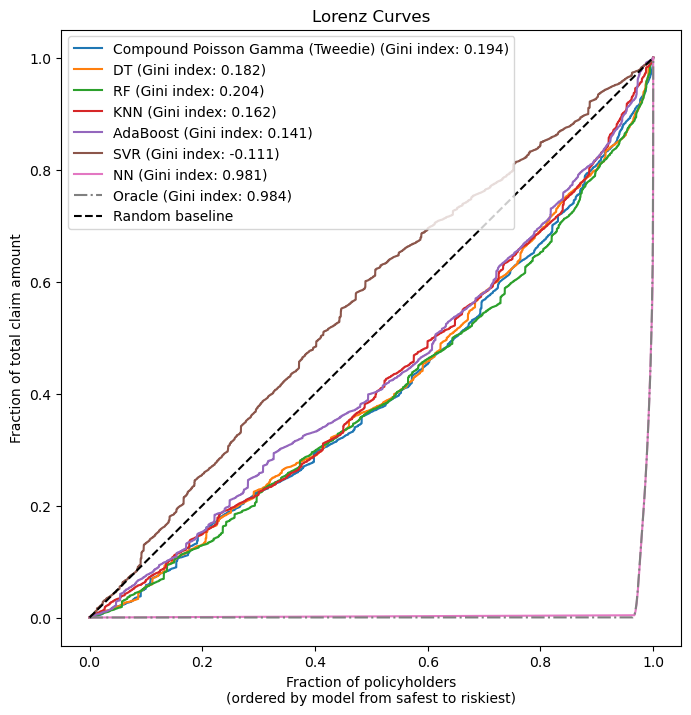

In [31]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_tweedie = TweedieRegressor_glm.predict(x_test) 
y_pred_rf = rf.predict(x_test)
y_pred_dt = dt.predict(x_test)
y_pred_knn = knn.predict(x_test)
y_pred_svr = svr.predict(x_test)
y_pred_ada = adaboost.predict(x_test)
y_pred_nn = nn.predict(x_test)

#y_pred_dummy = dummy.predict(x_test)


for label, y_pred in [
    ("Compound Poisson Gamma (Tweedie)", y_pred_tweedie),
    #("Dummy regressor", y_pred_dummy),
     ("DT", y_pred_dt),
     ("RF", y_pred_rf),
     ("KNN", y_pred_knn),
     ("AdaBoost", y_pred_ada),
     ("SVR", y_pred_svr),
     ("NN", y_pred_nn),

]:
    ordered_samples, cum_claims = lorenz_curve(
        y_test, y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    y_test, y_test, df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()

# 6. Plots  <a class="anchor" id="plots"></a>

In [2]:
# RMSE Plot
rmse = {'Tweedie GLM': 8299.567, 'DT': 8317.479, 'RF': 8321.035, 'AdaBoost': 8706.247, \
       'KNN': 8604.724, 'NN': 7270.281, 'SVR': 8301.553}

rmse_sorted = dict(sorted(rmse.items(), key=lambda item: item[1]))
rmse_keys = list(rmse_sorted.keys())
rmse_values = list(rmse_sorted.values())

# MAE Plot
mae = {'Tweedie GLM': 278.263, 'DT': 280.098, 'RF': 282.385, 'AdaBoost': 489.531, \
       'KNN': 395.398,'NN': 44.905, 'SVR': 155.820}

mae_sorted = dict(sorted(mae.items(), key=lambda item: item[1]))
mae_keys = list(mae_sorted.keys())
mae_values = list(mae_sorted.values())

#Tweedie Deviance Plot

td = {'Tweedie GLM': 68882809.945, 'DT': 69182185.507, 'RF': 69239621.659, 'AdaBoost': 75798731.666, \
       'KNN': 112083607.418,'NN': 1230600244.793, 'SVR': 68915789.584}

td_sorted = dict(sorted(td.items(), key=lambda item: item[1]))
td_keys = list(td_sorted.keys())
td_values = list(td_sorted.values())
sns.set(rc={'figure.figsize':(7, 5)})

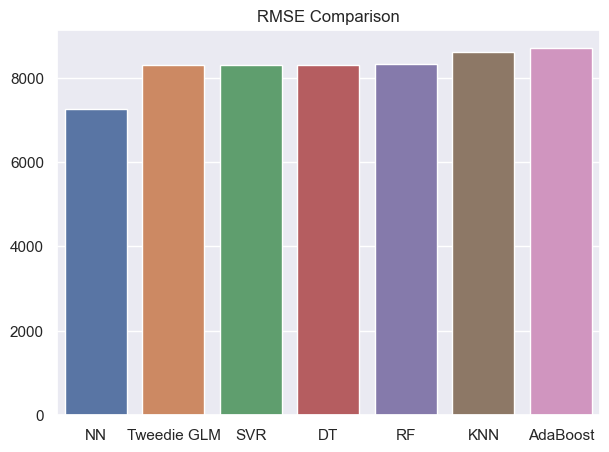

In [3]:
sns.barplot(x = rmse_keys, y = rmse_values).set(title='RMSE Comparison')
plt.show()

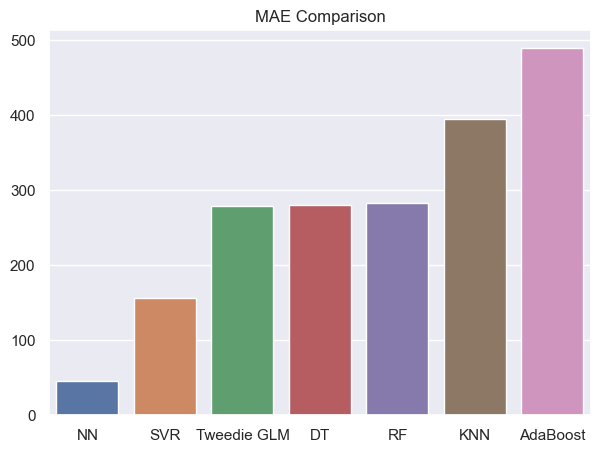

In [4]:
sns.barplot(x = mae_keys, y = mae_values).set(title='MAE Comparison')
plt.show()

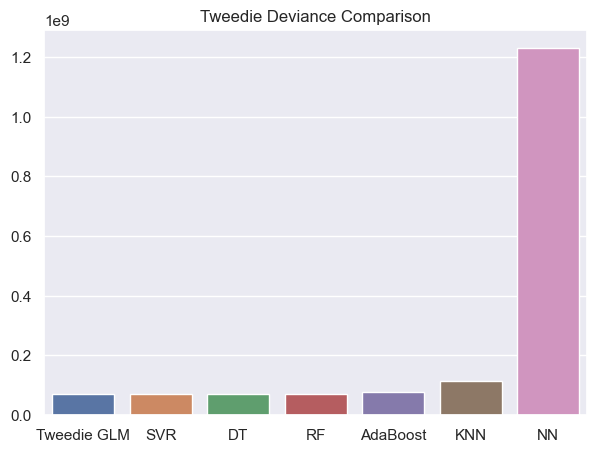

In [5]:
sns.barplot(x = td_keys, y = td_values).set(title='Tweedie Deviance Comparison')
plt.show()

In [11]:
old_rmse = {'Tweedie GLM': 5974.950, 'DT': 27436.163, 'RF': 14953.222, 'AdaBoost': 6410.362, 'KNN': 12280.208, 'SVR': 5971.862}

old_rmse_sorted = dict(sorted(old_rmse.items(), key=lambda item: item[1]))
old_rmse_keys = list(old_rmse_sorted.keys())
old_rmse_values = list(old_rmse_sorted.values())

old_mae = {'Tweedie GLM': 298.720, 'DT': 540.360, 'RF': 517.792, 'AdaBoost': 482.121, 'NN': 231.181, 'KNN': 434.530, 'SVR':151.880}

old_mae_sorted = dict(sorted(old_mae.items(), key=lambda item: item[1]))
old_mae_keys = list(old_mae_sorted.keys())
old_mae_values = list(old_mae_sorted.values())

old_td = {'Tweedie GLM': 35700031.108, 'DT': 1276373564.835, 'RF': 339601143.490, 'AdaBoost': 41092737.952, 'KNN':1589050231.092, 'SVR':35663131.942}

old_td_sorted = dict(sorted(old_td.items(), key=lambda item: item[1]))
old_td_keys = list(old_td_sorted.keys())
old_td_values = list(old_td_sorted.values())


rmse_metrics = {
    "Checkpoint 2": rmse,
    "Checkpoint 1": old_rmse,
}
mae_metrics = {
    "Checkpoint 2": mae,
    "Checkpoint 1": old_mae,
}
td_metrics = {
    "Checkpoint 2": td,
    "Checkpoint 1": old_td,
}

def sns_plot(model_metrics):
    
    #palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(palette)
    sns.set(rc={'figure.figsize':(10, 6)})
    fig2, ax = plt.subplots()
    
    imp_metrics = (pd.DataFrame(model_metrics).stack()
                     .rename_axis(index=['Model Names','Results'])
                     .reset_index(name='Value')
                  )    
    sns.barplot(data=imp_metrics, x='Model Names', y='Value', hue='Results',dodge = True).set(title='Tweedie Deviance Comparison')

    for p in ax.patches:
        ax.annotate(format(p.get_height()), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), textcoords = 'offset points')

    plt.show()

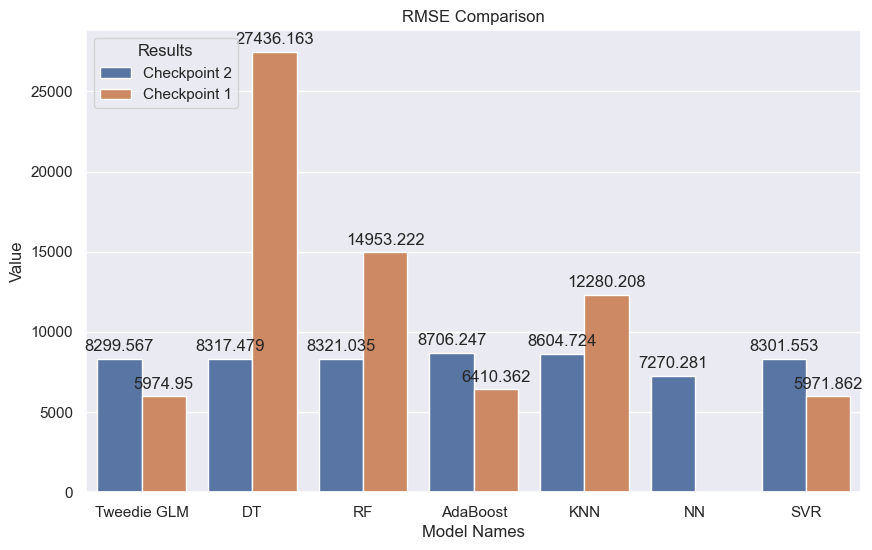

In [8]:
sns_plot(rmse_metrics)

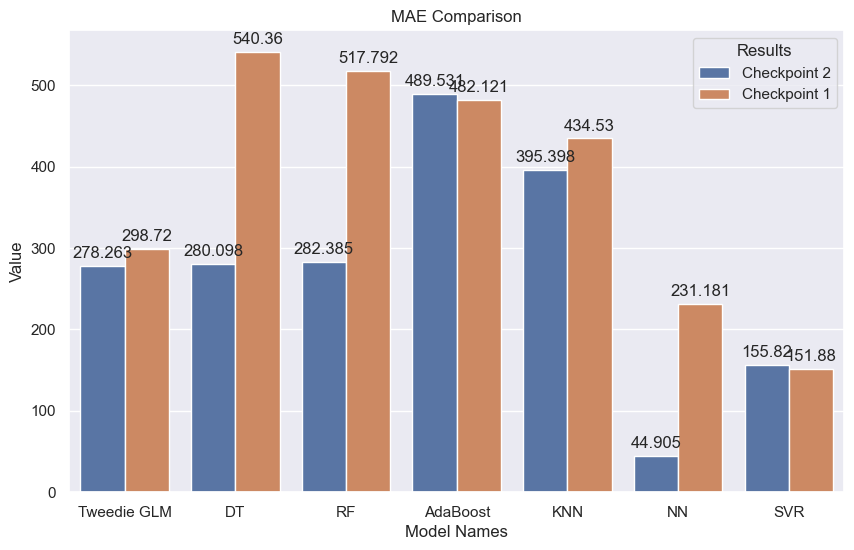

In [10]:
sns_plot(mae_metrics)

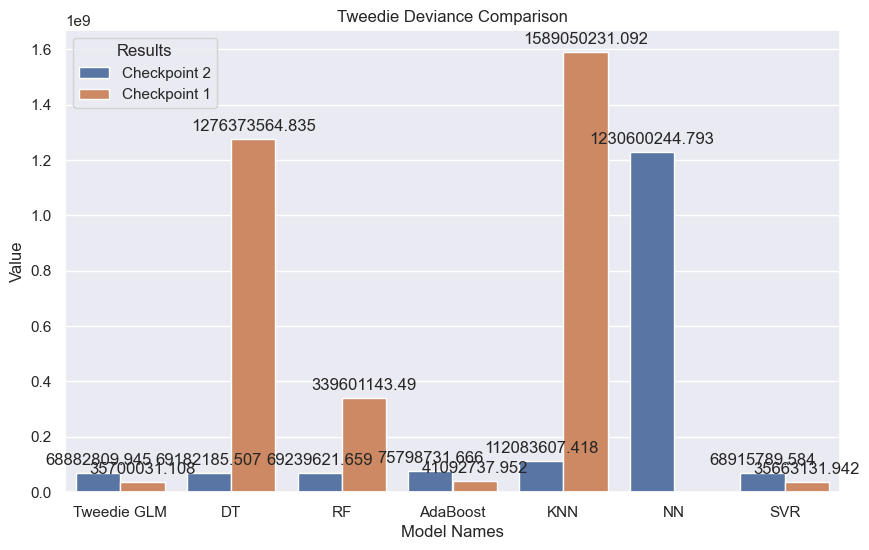

In [12]:
sns_plot(td_metrics)